# CA6011 Deep Learning for NLP: Week 1 Lab - Logistic Regression

**Logistic Regression** (sometimes called logit regression) estimates the parameters of a logistic model. In **binary logistic regression** there is a single dependent variable; in **multinomial logistic regression**, there are multiple dependent variables.

In this lab you will code, more or less from scratch, first (standard) logistic regression, and then multinomial logistic regression.

We provide a coding framework with a lot of the code in place, for you to add to. At two points during the lab, we will share partial solutions: after 45mins and after 90mins.

The remainder of the lab (for which we don't provide solutions) is for you to complete on your own, and must be submitted for assessment for Week 1 of this module (see module handbook).



Troughout this notebook, additional information can be found in the Week 1 lecture slides and Chapter 4 of the book **[Speech and Language Processing (3rd ed. draft) by Dan Jurafsky and James H. Martin](https://web.stanford.edu/~jurafsky/slp3/4.pdf)**.

In [1]:
# %matplotlib inline allows for displaying plots directly in the Jupyter notebook
%matplotlib inline

# NumPy is a library for numerical computations, with support for arrays and matrices
import numpy as np

# tqdm is used for creating progress bars to track the progress of for loops
from tqdm import tqdm

# Matplotlib is a plotting library, and we use it for tracking the loss values across iterations
import matplotlib.pyplot as plt

# make_classification is a function in the scikit-learn library to generate a random classification dataset
from sklearn.datasets import make_classification

# StandardScaler is a function in scikit-learn for standardising (scaling) the features of a dataset
from sklearn.preprocessing import StandardScaler

# train_test_split is a function in scikit-learn for splitting a dataset into training and testing sets
from sklearn.model_selection import train_test_split

# accuracy_score is a function in scikit-learn that implements the accuracy metric to evaluate classification models
from sklearn.metrics import accuracy_score

# IPython.display allows clearing the output in a Jupyter notebook cell
from IPython.display import clear_output

# Seed for reproducibility, fixing the random seed ensures consistent results when rerunning the code
seed = 42

##1  Logistic Regression

$\text{Decision}(x) = \begin{cases}
1 & \text{if } P(y = 1|x) > 0.5 \\
0 & \text{otherwise}
\end{cases}$


**$z = b + w_1 x_1 + w_2 x_2 + \ldots + w_n x_n$**

**$P(y = 1) = \frac{1}{1 + e^{-Z}}$** or $\frac{1}{1 + e^{-(b + w_1 x_1 + \ldots + w_n x_n)}}$

- $ x_1, x_2, \ldots, x_n $ are the input features.
- $b$ is the bias term.
- $w_1, w_2, \ldots, w_n$ are the corresponding weights.
- $\frac{1}{1 + e^{-Z}}$ or $\frac{1}{1 + e^{-(b + w_1 x_1 +  \ldots + w_n x_n)}}$ is the sigmoid function.


In this section, we develop an implementation of logistic regression and apply it to a synthetic dataset.

### 1.1 Dataset creation
First, we need to create a synthetic dataset to train the logistic regression. The dataset will contain **1000 samples**, or data points, where each sample has **5 features** classified into **2 classes**.

`make_classification` generates a random *n*-class classification problem; for more information, see its scikit-learn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html).

In [2]:
# Generate synthetic data
X, y = make_classification(n_samples=1000, n_features=5, n_classes=2, random_state=seed)

`X` holds the features for each data point or sample.

`y` holds a class label for each `X`.

In this context, `X` serves as the input for our regression model, while `y` represents the desired output from the model.

Refer to the lecture slides for explanation regarding the shapes of the different matrices, and the importance of getting shapes and order right.

In [3]:
# Check dataset shapes
print(f"Dataset inputs or features shape (num_samples, num_features): {X.shape}") # -> (1000, 5)
assert X.shape == (1000,5)  # checks whether the condition is True and returns an error if it's False
print(f"Dataset outputs or labels shape (num_samples, ): {y.shape}")  # -> (1000,)
assert y.shape == (1000,)

Dataset inputs or features shape (num_samples, num_features): (1000, 5)
Dataset outputs or labels shape (num_samples, ): (1000,)


In [4]:
# Display the first 10 data points and their class labels
for i in range(10):
    print(f"Data Point {i + 1}: Features = {X[i]}, Class Label = {y[i]}")

Data Point 1: Features = [-0.43964281  0.54254734 -0.82241993  0.40136622 -0.85484   ], Class Label = 0
Data Point 2: Features = [ 2.82223116 -2.48085944 -1.14769139 -2.10113103  3.04027792], Class Label = 1
Data Point 3: Features = [ 1.61838572 -1.36947785 -2.08411294 -1.17965857  1.61360231], Class Label = 1
Data Point 4: Features = [ 1.65904812 -0.61520205  1.11268837 -0.83509772 -0.27220548], Class Label = 1
Data Point 5: Features = [ 1.84982402 -1.67945551 -0.92669831 -1.40250885  2.12312866], Class Label = 1
Data Point 6: Features = [ 0.07711125  0.23716016  0.58441298  0.0872754  -0.66175283], Class Label = 0
Data Point 7: Features = [-0.38875395  0.56336538  0.01427307  0.39458146 -0.96012797], Class Label = 0
Data Point 8: Features = [ 2.04095851 -0.5083624  -1.77623523 -0.90945217 -0.94172241], Class Label = 1
Data Point 9: Features = [ 1.05244054 -0.04826718 -0.91750282 -0.36749269 -1.00799498], Class Label = 1
Data Point 10: Features = [ 0.76301635 -0.15836982  0.88688739 -

### 1.2 Data standardisation
Next, we check whether our data is already standardised or requires scaling to ensure that feature values have similar ranges.

Scaling dataset features, or ensuring similar scales is important, particularly for gradient-based optimisation (gradient decent) used in logistic regression. Similar feature scales enable faster convergence during the optimisation process, crucial for finding the minimum of the cost function. Moreover, feature scaling enhances numerical stability, as logistic regression involves exponential functions (Sigmoid function), preventing issues with very large or small input values and ensuring a stable optimisation process.

Refer to the lecture slides for more information regarding the importance of feature scaling.

Here we use standardisation. We will employ `StandardScaler` (Z-score standardisation), which standardises the data to have a mean of 0 and a standard deviation of 1. There are other scaling techniques, e.g. see [here](https://developers.google.com/machine-learning/data-prep/transform/normalization).

**Note:** We may not get exactly 0 mean or 1 standard deviation due to finite precision arithmetic in computers introducing small rounding errors. While these errors accumulate during calculations, their impact on the performance of the machine learning model (a regression model in our case) is typically negligible.

In [5]:
# Check means and standard deviations for each feature
means = X.mean(axis=0)
stds = X.std(axis=0)

print("Means of features:", means)
print("Standard deviations of features:", stds)

# If not standardised, apply Standard Scaling (Z-score standardisation)
if any(stds != 1) or any(means != 0):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    after_means = X.mean(axis=0)
    after_stds = X.std(axis=0)
    print("\nMeans of features after standardisation:", after_means)
    print("Standard deviations of features after standardisation:", after_stds)
else:
    print("Dataset is already standardised.")

Means of features: [-0.02254529  0.02970401  0.00875815  0.02147522 -0.04843296]
Standard deviations of features: [1.40325417 0.85853954 0.98707998 0.81769263 1.32147592]

Means of features after standardisation: [-1.11022302e-17 -9.32587341e-18  2.63122857e-17 -3.46389584e-17
 -3.77475828e-18]
Standard deviations of features after standardisation: [1. 1. 1. 1. 1.]


At this point, we need to initialise the Bias term ($b$) and concatenate it to the dataset.

In logistic regression, the bias term is represented by the intercept, serving as a term shared by all data points. To make the bias term learnable (allow gradient descent to find its value), we put in on a par with the input features, concatenating a column of ones to the feature matrix `X` as a constant feature (i.e. same feature value for all data points). This addition allows the model to learn a weight for this constant feature, ensuring the same value for all data points.

In [6]:
# Add bias term to X:
#np.ones(X.shape[0]): This creates a column vector of ones with the same number of rows as X
#np.c_: This concatenates the column vectors of the first matrix with the second matrix.
#np.c_[np.ones(X.shape[0]), X]: This concatenates the one column of the first matrix, np.ones(X.shape[0]), with the second matrix, X.

X = np.c_[np.ones(X.shape[0]), X]

print('X Shape:', X.shape)  # -> (1000, 6)
assert X.shape == (1000, 6)

X Shape: (1000, 6)


In [7]:
# Display the first 10 items in the synthetic dataset and their class labels after adding the bias term
for i in range(10):
    print(f"Data Item {i + 1}: Features = {X[i]}, Class Label = {y[i]}")

Data Item 1: Features = [ 1.         -0.2972359   0.59734387 -0.84205748  0.464589   -0.61023211], Class Label = 0
Data Item 2: Features = [ 1.          2.02727098 -2.92422578 -1.17158646 -2.59584857  2.33731909], Class Label = 1
Data Item 3: Features = [ 1.          1.16937548 -1.62972326 -2.12026495 -1.46893067  1.25771136], Class Label = 1
Data Item 4: Features = [ 1.          1.19835269 -0.7511664   1.11837971 -1.0475488  -0.1693353 ], Class Label = 1
Data Item 5: Features = [ 1.          1.33430518 -1.99077555 -0.94770077 -1.74146618  1.64328505], Class Label = 1
Data Item 6: Features = [ 1.          0.07101817  0.24163843  0.58318965  0.08047056 -0.46411733], Class Label = 0
Data Item 7: Features = [ 1.         -0.26097101  0.62159207  0.0055871   0.45629155 -0.68990664], Class Label = 0
Data Item 8: Features = [ 1.          1.47051322 -0.62672293 -1.80835739 -1.13848083 -0.6759786 ], Class Label = 1
Data Item 9: Features = [ 1.          0.76606637 -0.0908184  -0.93838492 -0.4756

Next, we split the dataset into train and test, so that we can use the train set to train and update the weights of our model and the test set to evaluate the performance of our final model.

We divide the dataset into 80% train and 20% test.

For more information see the documentation on [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) function.

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Check training/test sets shapes
print(f"Training set shape (num_train_samples , (num_features+bias)): {X_train.shape}") # -> (800, 6)
assert X_train.shape == (800, 6)
print(f"Test set shape (num_test_samples , (num_features+bias)): {X_test.shape}") # -> (200, 6)
assert X_test.shape == (200, 6)

Training set shape (num_train_samples , (num_features+bias)): (800, 6)
Test set shape (num_test_samples , (num_features+bias)): (200, 6)


### 1.3 Logistic Function: Sigmoid Function definition
Following the definition of Sigmoid function

> **$P (y = 1) = \frac{1}{1 + e^{-z}}$**

 we implement a function that calculates the Sigmoid for a given $z$, where

 **$z = b + w_1 x_1 + w_2 x_2 + \ldots + w_n x_n$**.

 Insert your own code below. Hint: use `numpy.exp` to calculate the exponential (see [here](https://numpy.org/doc/stable/reference/generated/numpy.exp.html)).

In [9]:
def sigmoid(Z: np.ndarray):
  """
    Sigmoid function that gives us the predictions of the given samples using our model.

    Args:
        Z (array): array with dimension (num_samples, ), each row contains z = b + w_1 x_1 + w_2 x_2 + ... + w_n x_n

    Returns:
        array with dimension (num_samples, ): array containing a prediction made by the model for each sample.
  """
  return 1 / (1 + np.exp(-Z))

### 1.4 Training Phase
In this section, we define the training procedure.

#### 1.4.1 Initialise Weights \( $w_1, w_2, \ldots, w_n$ \)

We need to initialise one weight for each dataset feature, giving a vector of length num_features + 1 (for the bias).

Insert your own code below, to initialise all the weights to 0.

In [10]:
# Initialise weights (one for each feature)

## INSERT YOUR CODE HERE ##
weights = np.zeros(X.shape[1])
## END OF YOUR CODE ##

# Check weights shape
print(f"Weights Shape (num_features+bias, ): {weights.shape}")  # -> (6,)
assert weights.shape == (6,)

Weights Shape (num_features+bias, ): (6,)


#### 1.4.2 Hyperparameters

In order to train our Logistic Regression, we need to define the hyperparameters. In this case, we need to define:

1.   **Learning rate**, i.e. how much we update the weights at each iteration;
2.   **Number of iterations**, i.e. how many times we iterate on the training dataset to update the weights.


In [11]:
# Learning rate and number of iterations
learning_rate = 0.01
num_iterations = 1000

#### 1.4.3 Training Loop

##### **Cross Entropy Loss**

To train our model, we need to have a loss function and understand how to update the weights of the model.

As explained in the lecture, Cross Entropy loss $\text{L}$ expresses, for an observation $x$, how close the classifier output is to the correct output ($y$, which is 0 or 1).

Recall that the system's output is $\hat{y} = \sigma(w \cdot x + b)$, where $\sigma$ is the sigmoid function, and $z = w \cdot x + b$ .

So, we aim to find the parameters $w$, $b$ that minimize the negative log probability of the true $y$ labels in the training data given the observations $x$. As explained in the lecture, this gives us the cross entropy loss:

$\text{L}_{\text{CE}}(\hat{y}, y) = - [y \log σ (w \cdot x + b) + (1 - y) \log (1 - \sigma (w \cdot x + b))]$

By following the gradients of the loss function, we can get incrementally closer to the optimal solution (provided the learning rate is not too big), as it's associated with a convex loss surface.

At any point during the learning process, the loss value tells us how good the model currently is.

We incrementally update the weights on the basis of the loss function gradients.

The gradients are calculated by taking the partial first derivative (giving the slope) of the Cross Entropy loss function with respect to each weight in turn (see lecture slides).

Once we have the full vector of gradients *g*, we use it to update the weights as part of Stochastic Gradient Descent (Section 5.6 - Figure 5.6):

$w = w - \eta * g$,

where $\eta$ is the learning rate.

It's important to identify the right learning rate because if we set it too high, we may skip the maximum point and if we set it too low we may end up in a local maximum.

##### **Training Steps**

In each training iteration, we need to perform different steps:

<ol>
<li> Calculate $z$ as the product between the weights and the features of the samples:
$z = b + w_1 x_1 + w_2 x_2 + \ldots + w_n x_n$
<li> Use <code>Z</code> to get the predictions of the samples using our model (softmax function);
<li> Use cross entropy loss to calculate the gradient (as the basis for the update in weights):
  <ol type=a>
  <li> Compute the difference (error) between the predictions and the real labels in the dataset (<code>y_train</code>) for each data point;
  <li> Multiply each error with its corresponding input $x$;
  </ol>
<li> Update the weights vector.
</ol>

In our implementation, we use Batch Gradient Descent (using the full dataset) when updating weights. Refer to the lecture slides for details.

Insert your code where indicated below. The only numpy function required is the [np.dot function](https://numpy.org/doc/stable/reference/generated/numpy.dot.html).

Hint: make sure to keep track of the shapes of matrices. You can print out their shapes as we did above in order to check; however, to maintain a clean display of your code, print only the shapes of the first iteration (when i=0).

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Z Shape (num_train_samples, ): (800,)
Predictions Shape (num_train_samples, ): (800,)
Error Shape (num_train_samples, ): (800,)
Gradient Shape (num_features+bias, ): (6,)
Weights Shape (num_features+bias, ): (6,)


Training: 100%|██████████| 1000/1000 [00:00<00:00, 5160.02it/s]


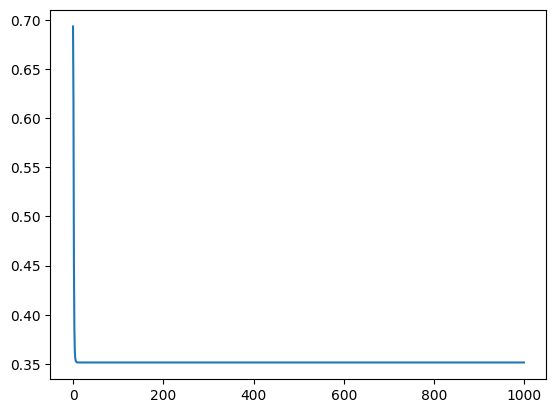

In [12]:
# Training the model
losses = []
# tqdm is a function that given a list, the total number of iterations and a description,
# returns a progressbar showing the time execution
for i in tqdm(range(num_iterations), total=num_iterations, desc="Training"):
  ## INSERT YOUR CODE HERE ##

  # 1. Calculate Z
  # X_train: (num_train_samples, num_features+bias) x weights: (num_features+bias, ) -> Z: (num_train_samples, )
  Z = np.dot(X_train, weights)
  if i==0:
    print('Z Shape (num_train_samples, ):', Z.shape)  # -> (800,)
    assert Z.shape == (800,)

  # 2. Get the predictions
  # Z: (num_train_samples, ) -> predictions: (num_train_samples, )
  predictions = sigmoid(Z)
  if i==0:
    print('Predictions Shape (num_train_samples, ):', predictions.shape) # -> (800,)
    assert predictions.shape == (800,)

  # 3.1. Compute errors between predictions and real labels
  # predictions: (num_train_samples, ) - y_train: (num_train_samples, ) -> errors: (num_train_samples, )
  errors = predictions - y_train
  if i==0:
    print('Error Shape (num_train_samples, ):', errors.shape) # -> (800,)
    assert errors.shape == (800,)

  # 3.2. Calculate gradient
  # we transpose X_train to align the dimensions correctly with the error dimension for matrix multiplication.
  # X_train.T: (num_features+bias, num_train_samples) x error: (num_train_samples, ) -> gradient or change in weights vector: (num_features+bias, )
  gradients = np.dot(X_train.T, errors)
  if i==0:
    print('Gradient Shape (num_features+bias, ):', gradients.shape) # -> (6,)
    assert gradients.shape == (6,)

  # 5. Update weights
  # gradient: (num_features+bias, ) -> weights: (num_features+bias, )
  weights -= learning_rate * gradients
  if i==0:
    print('Weights Shape (num_features+bias, ):', weights.shape) # -> (6,)
    assert weights.shape == (6,)
  ## END OF YOUR CODE ##

  loss = (-y_train * np.log(predictions) - (1 - y_train) * np.log(1 - predictions)).mean()

  losses.append(loss)

plt.plot(losses)
plt.show()

### 1.5 Evaluate the trained model

Finally, we want to evaluate the trained model on the test set to check the performance.

We use the final weights obtained from training and we compute the predictions of our test set.

We compare the predictions against the gold labels to calculate the accuracy of our model.

Given the predictions of our model and the gold labels, Accuracy is defined as follows:

$\text{Accuracy} = \frac{TP + TN}{TP + FP + TN + FN}$

- TP (True Positives): The number of instances that are actually positive (belong to the positive class) and are correctly predicted as positive by the model.

- TN (True Negatives): The number of instances that are actually negative (belong to the negative class) and are correctly predicted as negative by the model.

- FP (False Positives): The number of instances that are actually negative but are incorrectly predicted as positive by the model.

- FN (False Negatives): The number of instances that are actually positive but are incorrectly predicted as negative by the model.

In [13]:
# Making predictions on the test set using trained weights
# X_test: (num_test_samples, num_features) x weights: (num_features, ) -> Z: (num_samples, )
z = np.dot(X_test, weights)
test_predictions = sigmoid(z)

'''
Recall: Decision(x) = 1 if P(y = 1|x) > 0.5, Decision(x) = 0 otherwise
np.round below will set any probability(test_predictions) greater than the threshold 0.5 to 1, and to 0 otherwise.
'''
binary_predictions = np.round(test_predictions)

# Compute Accuracy using gold labels and predictions
accuracy = accuracy_score(y_test, binary_predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.88


## 2  Multinomial Logistic Regression

Standard logistic regression is for binary classification (there is one class, and instances either belong to it or they don't). **Multinomial Logistic Regression** is a generalisation to multi-class classification. Instead of using the Sigmoid function, it uses Softmax to obtain a probability distribution over the $K$ classes.

Other than that, we also now need $K$ weight vectors and gradient vectors rather than single ones as in standard (binary) logistic regression.


**Multinomial Logistic Regression modelling:**

$P(Y_k=1 | X) = \frac{\text{exp}(W_k \cdot X + b_k)}{\sum_{j=1}^{K} \text{exp}(W_j \cdot X + b_j)}$

 - $K$ is the number of classes,
 - $\frac{\text{exp}(W_k \cdot X + b_k)}{\sum_{j=1}^{K} \text{exp}(W_j \cdot X + b_j)}$ is the softmax function


 Refer to the lecture slides for details.

In this section, we develop an implementation of multinomial logistic regression, and apply it to a real-world dataset.

#### 2.1 Dataset

Instead of creating a toy dataset as we did in Section 1.1, in this section we'll use a real world dataset.

We use the **[AGnews dataset](https://huggingface.co/datasets/wangrongsheng/ag_news)** composed of news articles categorised by domain. The dataset contains 4 domains: *World*; *Sports*, *Business*, and *Science/Technology*.

The dataset is already divided into train and test sets containing 120K and 7.6K samples, respectively.

For this exercise, we are going to exclude the World category.

First, we download all the files composing the dataset.

In [14]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1QfAUt0u4wLZVy2Ta1G90jOLNaqzAw2eW' -O agnews_test.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1UsOBTnfch-Su4kqmkzXcIizwJt6NWtXZ' -O agnews_train.csv
clear_output()

Now we are able to load the dataset and preprocess it. We use the labels *sports, business* and *science* for our three news domains.

In [15]:
import pandas as pd

# labels contained in the dataset
labels = ['sports', 'business', 'science']

# dataset is saved in a CSV file with no header and each column in separated by comma
# the file has the following structure:
# gold_label , title , body
df = pd.read_csv('agnews_train.csv', header=None)

# in the dataset gold labels are given as: 1 (World), 2 (Sports), 3 (Business), 4 (Science/Technology)
# we discard all the rows with gold label 1 (World) and we keep all the other rows
df = df[df[0] != 1]

# we create a 'label' column, subtract 2 from each gold label so we obtain a direct mapping with our list of labels:
# 0 -> sports ; 1 -> business ; 2 -> science
df['label'] = df[0]-2

# we concatenate title and body to obtain a unified text
df['text'] = [" ".join((title, body)) for title, body in zip(df[1], df[2])]
# remove the original 3 columns to obtain our final processed dataset, containing 2 columns: label and text
# the original 3 columns are the unmatched labels, the titles and the bodies
processed_df = df.drop(columns=[0,1,2])
processed_df.head(10)

,label,text
0,1,Wall St. Bears Claw Back Into the Black (Reute...
1,1,Carlyle Looks Toward Commercial Aerospace (Reu...
2,1,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,1,Iraq Halts Oil Exports from Main Southern Pipe...
4,1,"Oil prices soar to all-time record, posing new..."
5,1,"Stocks End Up, But Near Year Lows (Reuters) Re..."
6,1,Money Funds Fell in Latest Week (AP) AP - Asse...
7,1,Fed minutes show dissent over inflation (USATO...
8,1,Safety Net (Forbes.com) Forbes.com - After ear...
9,1,Wall St. Bears Claw Back Into the Black NEW Y...


In order to process text, we need to identify features that our model can use to classify texts.

We use four hand-crafted features:

1.  natural logarithm of text length;
2.  number of sports words in the text;
3.  number of business words in the text;
4.  number of science words in the text.

Next, we download a list of words for each target label to compute our features. We get the lists of words from [Enchanted Learning - Wordlist](https://www.enchantedlearning.com/wordlist/).

In [16]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XWzN3nBPcWp50f_DjC2rpS7G2PvzjvmB' -O business.txt
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1u3KQGgkFTN8s4fTGzJJOsmR4MGVlusp1' -O science.txt
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1g_gYaij_xn1HwGebruK3JJRZy30P7E49' -O sports.txt
clear_output()

In [17]:
# computes the features of the given text and returns a list of features in the format:
# [ln text_len, # sports words, # business words, # science words]
def get_features_text(text: str):
  """
    Calculated text features for the given text.

    Args:
        text (string): string containing the text.

    Returns:
        List with dimension 4: list containing the features extracted from the text in the order
                                [ln text_len, # sports words, # business words, # science words].
    """
  import math
  # divide the text into words
  words = text.split()

  # initialise the features list adding the ln of the text length
  features = [math.log(len(words))]

  # for each target label we have in the dataset
  for label in labels:
    # open the list of words of the current label
    with open(f'{label}.txt', 'r') as label_file:
      # get all the words associated to the current label
      # the file contains 1 word for each line, so we split the whole text with \n
      label_words = label_file.read().split('\n')
    label_count = 0
    # for each word in the text,
    for word in words:
      # check if the word is present in the list of words associated to the current label
      if word in label_words:
        # if it's present add 1 to the current count
        label_count += 1
    # append the final count to the features list
    features.append(label_count)
  # return the features list [ln text_len, # sports words, # business words, # science words]
  return features

In [18]:
# create a new column containing the features calculated as described above
processed_df['text_features'] = [get_features_text(text) for text in processed_df['text']]
processed_df.head(10)

,label,text,text_features
0,1,Wall St. Bears Claw Back Into the Black (Reute...,"[3.044522437723423, 0, 0, 0]"
1,1,Carlyle Looks Toward Commercial Aerospace (Reu...,"[3.58351893845611, 1, 1, 0]"
2,1,Oil and Economy Cloud Stocks' Outlook (Reuters...,"[3.58351893845611, 0, 3, 0]"
3,1,Iraq Halts Oil Exports from Main Southern Pipe...,"[3.58351893845611, 0, 0, 0]"
4,1,"Oil prices soar to all-time record, posing new...","[3.6109179126442243, 0, 1, 0]"
5,1,"Stocks End Up, But Near Year Lows (Reuters) Re...","[3.6375861597263857, 0, 0, 1]"
6,1,Money Funds Fell in Latest Week (AP) AP - Asse...,"[3.5553480614894135, 0, 3, 0]"
7,1,Fed minutes show dissent over inflation (USATO...,"[3.6635616461296463, 0, 4, 0]"
8,1,Safety Net (Forbes.com) Forbes.com - After ear...,"[4.219507705176107, 1, 8, 0]"
9,1,Wall St. Bears Claw Back Into the Black NEW Y...,"[3.1354942159291497, 0, 0, 0]"


In [19]:
# extract X (text_featues) and y (label) from the dataset
X = np.array(processed_df['text_features'].to_list())
y_train = processed_df['label'].to_list()

In [20]:
# Check dataset shapes
print(f"Dataset inputs or features shape (num_samples, num_features): {X.shape}") # -> (90000, 4)
assert X.shape == (90000, 4)
print(f"Dataset outputs or labels shape (num_samples, ): {len(y_train)}") # -> 90000
assert len(y_train) == 90000

Dataset inputs or features shape (num_samples, num_features): (90000, 4)
Dataset outputs or labels shape (num_samples, ): 90000


### 2.2 Data Standardisation

We need to standardise our data for the same reasons as discussed for simple logistic regression above, but since our training and test set are in different files we will package the data standardisation in a function, so we can reuse it: first to standardise the training set, and then for the test set during evaluation.

In [21]:
#We commented all print statements for clean code display -- uncomment as needed
def standardise_features(X: np.ndarray):
    """
      Standardise the features contained in the given dataset.

      Args:
          X (array): array with dimension (num_samples, num_features).

      Returns:
          array with dimension (num_samples, num_features): dataset with standardised features.
    """
    # Check means and standard deviations for each features
    means = X.mean(axis=0)
    stds = X.std(axis=0)

    #print("Means of features:", means)
    #print("Standard deviations of features:", stds)

    # If not standardised, apply Standard Scaling (Z-score standardisation)
    if any(stds != 1) or any(means != 0):
        scaler = StandardScaler()
        standardised_X = scaler.fit_transform(X)
        #after_means = X.mean(axis=0)
        #after_stds = X.std(axis=0)
        #print("\nMeans of features after standardisation:", after_means)
        #print("Standard deviations of features after standardisation:", after_stds)
    else:
        print("Dataset is already standardised.")
    return standardised_X

In [22]:
X_standardised = standardise_features(X) #standardise train set

As we did before, we need to initialise the Bias term ($b$) and concatenate it to the dataset.

In [23]:
# Add bias term to X
X_train = np.c_[np.ones(X_standardised.shape[0]), X]

In [24]:
# Check training sets shapes
print(f"Training set shape (num_samples x (num_features+bias)): {X_train.shape}") # -> (90000, 5)
assert X_train.shape == (90000, 5)

Training set shape (num_samples x (num_features+bias)): (90000, 5)


### 2.3 Logistic Function: Softmax Function definition

Following the definition of Softmax function

**$\text{softmax}(Z_i) = \frac{\text{exp}(Z_i)}{\sum_{j=1}^{K} \text{exp}(Z_j)}$**

 implement a function that calculates the Softmax for a given Z.

 The sum of the exponentials ($\sum_{j=1}^{K} \text{exp}(Z_j)$) may lead to very large numbers, this could cause instability in calculating the gradients. To avoid this, we reduce each value $Z_i$ by subtracting from the largest value in the input ([Softmax Function Reference](https://en.wikipedia.org/wiki/Softmax_function)):



 **$\text{softmax}(Z_i) = \frac{\text{exp}(Z_i - \text{max}(Z))}{\sum_{j=1}^{K} \text{exp}(Z_j - \text{max}(Z))}$**

 Hint: use numpy to calculate the exponential, the max and the sum.

 **Note:** As we will take the max and the sum along each row (that means we perform these operations on columns), this will result in a matrix with only one dimension instead of two, and becuase there are other operators (e.g. exponential) that don't change the number of dimensions, we need to keep the dimension when applying the max and the sum operations (Search for parameters in max and sum numpy reference that can keep the dimensions).

In [25]:
def softmax(Z: np.ndarray):
  """
    Softmax function that gives us the predictions of the given samples using our model.

    Args:
        Z (array): array with dimension (num_train_samples, num_class), each row contains z = b + w_1 x_1 + w_2 x_2 + ... + w_n x_n

    Returns:
        array with dimension (num_train_samples, num_class): array containing a prediction made by the model for each sample.
  """
  ## INSERT YOUR CODE HERE ##
  exp_Z = (np.exp(Z - np.max(Z)))/np.sum(np.exp(Z) - np.max(Z))
  return exp_Z
  ## END OF YOUR CODE ##

### 2.4 Training Phase

#### 2.4.1 Initialise Weights \( $w_1, w_2, \ldots, w_n$ \)

We need to initialise 1 weight for each class in the dataset for each feature composing a sample in our dataset.

First, you need to identify the number of classes, then you can inizialise the correct number of weights.

You can initialise all the weights to 0.

In [26]:
# Initialize weights

# Before, we had a single vector of weights with dimension (6,)
# Now we need 1 weight for each feature+bias and for each class in the dataset
# obtaining a matrix with dimensions (num_features+bias, num_classes).
# The initialisation is similar to before, but we need to identify the number of classes
# to initialise a matrix with the correct dimensions.

## INSERT YOUR CODE HERE ##
# num_classes = 3
num_classes = len(np.unique(y_train))
weights = np.zeros((X_train.shape[1], num_classes))
## END OF YOUR CODE ##

# Check weights shape
print(f"Weights Shape (num_features+bias, num_classes): {weights.shape}") # -> (5, 3)
assert weights.shape == (5, 3)

Weights Shape (num_features+bias, num_classes): (5, 3)


#### 2.4.2 Hyperparameters



In [27]:
# Learning rate and number of iterations
learning_rate = 0.001
num_iterations = 5000

#### 2.4.3 Training Loop

In each training iteration, we need to perform different steps:

1.   Calculate Z
2.   Use Z to get the predictions of the samples using our model;
3.   Compute the error (loss function) between the predictions and the real labels in the dataset (*y_train*);
4.   Calculate the gradient based on the obtained error;
5.   Update the weights.

You may use numpy functions [np.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) and [np.eye](https://numpy.org/devdocs/reference/generated/numpy.eye.html).

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Z Shape (num_train_samples, num_class): (90000, 3)
Predictions Shape (num_train_samples, num_class): (90000, 3)
Error Shape (num_train_samples, ): (90000, 3)
Gradient Shape (num_features+bias, num_class): (5, 3)
Weights Shape (num_features+bias, num_class): (5, 3)


/tmp/ipython-input-4001610020.py:12: RuntimeWarning: overflow encountered in exp
  exp_Z = (np.exp(Z - np.max(Z)))/np.sum(np.exp(Z) - np.max(Z))
Training: 100%|██████████| 5000/5000 [04:09<00:00, 20.04it/s]


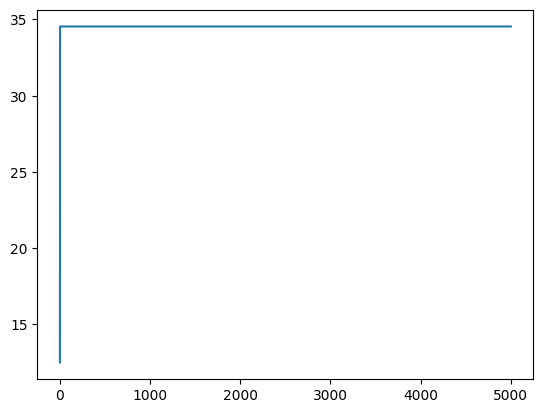

In [28]:
# Training the model
# You can comment the print functions for a clear output after you complete coding all the training steps.
losses = []
for i in tqdm(range(num_iterations), total=num_iterations, desc="Training"):

  ## INSERT YOUR CODE HERE ##
  # 1. Calculate Z
  # X_train: (num_train_samples, num_features+bias) x weights: (num_features+bias, num_class) -> Z: (num_train_samples, num_class)
  Z = np.dot(X_train, weights)
  if i==0:
    print('Z Shape (num_train_samples, num_class):', Z.shape) # -> (90000, 3)
    assert Z.shape == (90000, 3)

  # 2. Get predictions
  # Z: (num_train_samples, num_class) -> predictions: (num_train_samples, num_class)
  predictions = softmax(Z)
  if i==0:
    print('Predictions Shape (num_train_samples, num_class):', predictions.shape) # -> (90000, 3)
    assert predictions.shape == (90000, 3)

  # 3. Compute error between prediction and real label
  '''
  The prediction for each data item is a vector of probabilites summing to 1.
  For example, if we have a prediction for a data point like this: [0.2, 0.5, 0.3],
  we can read this as there is 0.2 probability that the data item belongs to the first class,
  0.5 to the second class, and 0.3 to the third class. Our gold label is just the index
  of the class, taking the values 0, 1 or 2. Let's assume our gold label is 2.
  To compare our predictions to the label, we need to represent the label in a comparable format.
  To achieve this, we can use one-hot encoding for the labels (setting 1 in the desired index and 0 elsewhere),
  giving the following for a label of 2: [0, 0, 1].
  This we can compare to the prediction, finding that we are off by 0.7 from the perfect true class probability (1).

  Hint: to get the one-hot encoding of the labels (y_train in our case), think about using np.eye() function
  '''
  # predictions: (num_train_samples, num_class) y_train: (num_train_samples, ) -> errors: (num_train_samples, num_class)
  y_train_one_hot = np.eye(num_classes)[y_train]
  errors = predictions - y_train_one_hot
  if i==0:
    print('Error Shape (num_train_samples, ):', errors.shape)  # -> (90000, 3)
    assert errors.shape == (90000, 3)

  # 4. Calculate gradient
  #  We transpose X_train to align the dimensions correctly with the error dimension for matrix multiplication.
  # X_train.T: (num_features+bias, num_train_samples) x error: (num_train_samples, num_class) -> gradient or change in weights vector: (num_features+bias, num_class)
  gradients = np.dot(X_train.T, errors)
  if i==0:
    print('Gradient Shape (num_features+bias, num_class):', gradients.shape)  # -> (5, 3)
    assert gradients.shape == (5, 3)

  # 5. Update weights
  # gradient: (num_features+bias, num_class) -> weights: (num_features+bias, num_class)
  weights -= learning_rate * gradients
  if i==0:
    print('Weights Shape (num_features+bias, num_class):', weights.shape) # -> (5, 3)
    assert weights.shape == (5, 3)
  ## END OF YOUR CODE ##

  loss = -np.sum(y_train_one_hot * np.log(predictions+ 1e-15)) / len(y_train) # Add small epsilon to avoid log(0)
  losses.append(loss)

plt.plot(losses)
plt.show()

The shape of the loss function plotted is not decreasing as we observed in Section 1 because the features we extracted from the texts are not representative enough to allow the model to learn proper decision boundaries to select the correct label.

### 2.5 Evaluate the trained model

As we did in Section 1.5, we want to evaluate the trained model to check the performance.

1. We preprocess the test set as we did for the train set.
2. We use the final weights obtained from training and we compute the predictions of our test set.
3. We compare the predictions against the target labels to calculate the accuracy of our model.

In [29]:
def prepocess_data(filename):
  """
    Preprocess the given dataset to set it in the correct format, i.e.
    containing 2 columns (label, text_features) with standardised text features and adding bias to the features.
    This function collects all the steps described in details in Sections 2.1 and 2.2

    Args:
        filename (string): name of the file containing the dataset.

    Returns:
        X: bias+features extracted from the samples in the dataset.
        y: gold labels of the dataset.
  """
  df = pd.read_csv(filename, header=None)
  df = df[df[0] != 1]
  df['label'] = df[0]-2
  df['text'] = [" ".join((title, body)) for title, body in zip(df[1], df[2])]
  df = df.drop(columns=[0,1,2])

  df['text_features'] = [get_features_text(text) for text in df['text']]

  X = np.array(df['text_features'].to_list())
  X_standardised = standardise_features(X) #standardise test set
  X = np.c_[np.ones(X_standardised.shape[0]), X_standardised]

  y = df['label'].to_list()

  return X, y

X_test, y_test = prepocess_data('agnews_test.csv')

print(f"Test set shape (num_test_samples , (num_features+bias)): {X_test.shape}") # -> (5700, 5)
assert X_test.shape == (5700, 5)

Test set shape (num_test_samples , (num_features+bias)): (5700, 5)


In [30]:
# Making predictions on the test set using trained weights
# X_test: (num_test_samples, num_features) x weights: (num_features, num_class) -> Z: (num_samples, num_class)
z = np.dot(X_test, weights)
test_predictions = softmax(z)

# select the class with the highest probability
multiclass_predictions = np.argmax(test_predictions, axis=1)

# Evaluating the model
accuracy = accuracy_score(y_test, multiclass_predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.3333333333333333


/tmp/ipython-input-4001610020.py:12: RuntimeWarning: overflow encountered in exp
  exp_Z = (np.exp(Z - np.max(Z)))/np.sum(np.exp(Z) - np.max(Z))


## 3. Identify new text features (__Week 1 Submission Exercise__)

Using the code from Section 2 on Multinomial Logistic Regression as a starting point, create new text features for the same multi-class task and try to obtain better performance.

You can modify the features in the code provided in Section 2.1, in function `get_features_text`.

Copy all and only the required code to a new notebook, and submit it for Week 1. Make sure you print both original performance (with the features used in Section 2) and performance for your new features to screen.

Consult the module handbook for instructions how to share the weekly submission exercises with us.

# Resources

- Speech and Language Processing (3rd ed. draft) Dan Jurafsky and James H. Martin, [Chapter 4](https://web.stanford.edu/~jurafsky/slp3/4.pdf)
- [Enchanted Learning - Wordlist](https://www.enchantedlearning.com/wordlist/)
- [AG News dataset](https://huggingface.co/datasets/wangrongsheng/ag_news)

### 3.1 Creating new features
In order to improve performance we need to hand design more features that can help in classifying whether the text is part of one class more than another.

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1QfAUt0u4wLZVy2Ta1G90jOLNaqzAw2eW' -O agnews_test.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1UsOBTnfch-Su4kqmkzXcIizwJt6NWtXZ' -O agnews_train.csv

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XWzN3nBPcWp50f_DjC2rpS7G2PvzjvmB' -O business.txt
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1u3KQGgkFTN8s4fTGzJJOsmR4MGVlusp1' -O science.txt
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1g_gYaij_xn1HwGebruK3JJRZy30P7E49' -O sports.txt
clear_output()

Dataset inputs or features shape (num_samples, num_features): (90000, 4)
Dataset outputs or labels shape (num_samples, ): 90000
Training set shape (num_samples x (num_features+bias)): (90000, 5)
Weights Shape (num_features+bias, num_classes): (5, 3)


Training:   0%|          | 3/5000 [00:00<03:38, 22.90it/s]

Z Shape (num_train_samples, num_class): (90000, 3)
Predictions Shape (num_train_samples, num_class): (90000, 3)
Error Shape (num_train_samples, ): (90000, 3)
Gradient Shape (num_features+bias, num_class): (5, 3)
Weights Shape (num_features+bias, num_class): (5, 3)


Training: 100%|██████████| 5000/5000 [04:19<00:00, 19.27it/s]


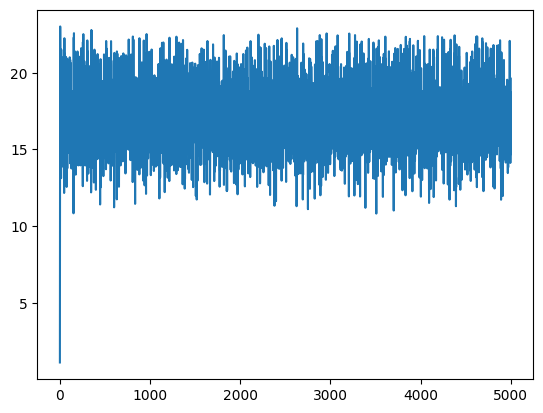

Test set shape (num_test_samples , (num_features+bias)): (5700, 5)
Accuracy: 0.5178947368421053


In [34]:
import pandas as pd

# labels contained in the dataset
labels = ['sports', 'business', 'science']

# dataset is saved in a CSV file with no header and each column in separated by comma
# the file has the following structure:
# gold_label , title , body
df = pd.read_csv('agnews_train.csv', header=None)

# in the dataset gold labels are given as: 1 (World), 2 (Sports), 3 (Business), 4 (Science/Technology)
# we discard all the rows with gold label 1 (World) and we keep all the other rows
df = df[df[0] != 1]

# we create a 'label' column, subtract 2 from each gold label so we obtain a direct mapping with our list of labels:
# 0 -> sports ; 1 -> business ; 2 -> science
df['label'] = df[0]-2

# we concatenate title and body to obtain a unified text
df['text'] = [" ".join((title, body)) for title, body in zip(df[1], df[2])]
# remove the original 3 columns to obtain our final processed dataset, containing 2 columns: label and text
# the original 3 columns are the unmatched labels, the titles and the bodies
processed_df = df.drop(columns=[0,1,2])
processed_df.head(10)

# computes the features of the given text and returns a list of features in the format:
# [ln text_len, # sports words, # business words, # science words]
def get_features_text(text: str):
  """
    Calculated text features for the given text.

    Args:
        text (string): string containing the text.

    Returns:
        List with dimension 4: list containing the features extracted from the text in the order
                                [ln text_len, # sports words, # business words, # science words].
    """
  import math
  # divide the text into words
  words = text.split()

  # initialise the features list adding the ln of the text length
  features = [math.log(len(words))]

  # for each target label we have in the dataset
  for label in labels:
    # open the list of words of the current label
    with open(f'{label}.txt', 'r') as label_file:
      # get all the words associated to the current label
      # the file contains 1 word for each line, so we split the whole text with \n
      label_words = label_file.read().split('\n')
    label_count = 0
    # for each word in the text,
    for word in words:
      word = word.strip().lower()
      # check if the word is present in the list of words associated to the current label
      if word in label_words:
        # if it's present add 1 to the current count
        label_count += 1
    # append the final count to the features list
    features.append(label_count)
  # return the features list [ln text_len, # sports words, # business words, # science words]
  return features

# create a new column containing the features calculated as described above
processed_df['text_features'] = [get_features_text(text) for text in processed_df['text']]
processed_df.head(10)

# extract X (text_featues) and y (label) from the dataset
X = np.array(processed_df['text_features'].to_list())
y_train = processed_df['label'].to_list()

# Check dataset shapes
print(f"Dataset inputs or features shape (num_samples, num_features): {X.shape}") # -> (90000, 4)
assert X.shape == (90000, 4)
print(f"Dataset outputs or labels shape (num_samples, ): {len(y_train)}") # -> 90000
assert len(y_train) == 90000

#We commented all print statements for clean code display -- uncomment as needed
def standardise_features(X: np.ndarray):
    """
      Standardise the features contained in the given dataset.

      Args:
          X (array): array with dimension (num_samples, num_features).

      Returns:
          array with dimension (num_samples, num_features): dataset with standardised features.
    """
    # Check means and standard deviations for each features
    means = X.mean(axis=0)
    stds = X.std(axis=0)

    #print("Means of features:", means)
    #print("Standard deviations of features:", stds)

    # If not standardised, apply Standard Scaling (Z-score standardisation)
    if any(stds != 1) or any(means != 0):
        scaler = StandardScaler()
        standardised_X = scaler.fit_transform(X)
        #after_means = X.mean(axis=0)
        #after_stds = X.std(axis=0)
        #print("\nMeans of features after standardisation:", after_means)
        #print("Standard deviations of features after standardisation:", after_stds)
    else:
        print("Dataset is already standardised.")
    return standardised_X

X_standardised = standardise_features(X) #standardise train set

# Add bias term to X
X_train = np.c_[np.ones(X_standardised.shape[0]), X]

# Check training sets shapes
print(f"Training set shape (num_samples x (num_features+bias)): {X_train.shape}") # -> (90000, 5)
assert X_train.shape == (90000, 5)

def softmax(Z: np.ndarray):
  """
    Softmax function that gives us the predictions of the given samples using our model.

    Args:
        Z (array): array with dimension (num_train_samples, num_class), each row contains z = b + w_1 x_1 + w_2 x_2 + ... + w_n x_n

    Returns:
        array with dimension (num_train_samples, num_class): array containing a prediction made by the model for each sample.
  """
  ## INSERT YOUR CODE HERE ##
  exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
  return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
  ## END OF YOUR CODE ##

  # Initialize weights

# Before, we had a single vector of weights with dimension (6,)
# Now we need 1 weight for each feature+bias and for each class in the dataset
# obtaining a matrix with dimensions (num_features+bias, num_classes).
# The initialisation is similar to before, but we need to identify the number of classes
# to initialise a matrix with the correct dimensions.

## INSERT YOUR CODE HERE ##
num_classes = len(np.unique(y_train))
weights = np.zeros((X_train.shape[1], num_classes))
## END OF YOUR CODE ##

# Check weights shape
print(f"Weights Shape (num_features+bias, num_classes): {weights.shape}") # -> (5, 3)
assert weights.shape == (5, 3)

# Learning rate and number of iterations
learning_rate = 0.001
num_iterations = 5000

# ------------------------------------
'''new code'''
# ------------------------------------
# Training the model
# You can comment the print functions for a clear output after you complete coding all the training steps.
losses = []
for i in tqdm(range(num_iterations), total=num_iterations, desc="Training"):

  ## INSERT YOUR CODE HERE ##
  # 1. Calculate Z
  # X_train: (num_train_samples, num_features+bias) x weights: (num_features+bias, num_class) -> Z: (num_train_samples, num_class)
  Z = np.dot(X_train, weights)
  if i==0:
    print('Z Shape (num_train_samples, num_class):', Z.shape) # -> (90000, 3)
    assert Z.shape == (90000, 3)

  # 2. Get predictions
  # Z: (num_train_samples, num_class) -> predictions: (num_train_samples, num_class)
  predictions = softmax(Z)
  if i==0:
    print('Predictions Shape (num_train_samples, num_class):', predictions.shape) # -> (90000, 3)
    assert predictions.shape == (90000, 3)

  # 3. Compute error between prediction and real label
  '''
  The prediction for each data item is a vector of probabilites summing to 1.
  For example, if we have a prediction for a data point like this: [0.2, 0.5, 0.3],
  we can read this as there is 0.2 probability that the data item belongs to the first class,
  0.5 to the second class, and 0.3 to the third class. Our gold label is just the index
  of the class, taking the values 0, 1 or 2. Let's assume our gold label is 2.
  To compare our predictions to the label, we need to represent the label in a comparable format.
  To achieve this, we can use one-hot encoding for the labels (setting 1 in the desired index and 0 elsewhere),
  giving the following for a label of 2: [0, 0, 1].
  This we can compare to the prediction, finding that we are off by 0.7 from the perfect true class probability (1).

  Hint: to get the one-hot encoding of the labels (y_train in our case), think about using np.eye() function
  '''
  # predictions: (num_train_samples, num_class) y_train: (num_train_samples, ) -> errors: (num_train_samples, num_class)
  y_train_one_hot = np.eye(num_classes)[y_train]
  errors = predictions - y_train_one_hot
  if i==0:
    print('Error Shape (num_train_samples, ):', errors.shape)  # -> (90000, 3)
    assert errors.shape == (90000, 3)

  # 4. Calculate gradient
  #  We transpose X_train to align the dimensions correctly with the error dimension for matrix multiplication.
  # X_train.T: (num_features+bias, num_train_samples) x error: (num_train_samples, num_class) -> gradient or change in weights vector: (num_features+bias, num_class)
  gradients = np.dot(X_train.T, errors)
  if i==0:
    print('Gradient Shape (num_features+bias, num_class):', gradients.shape)  # -> (5, 3)
    assert gradients.shape == (5, 3)

  # 5. Update weights
  # gradient: (num_features+bias, num_class) -> weights: (num_features+bias, num_class)
  weights -= learning_rate * gradients
  if i==0:
    print('Weights Shape (num_features+bias, num_class):', weights.shape) # -> (5, 3)
    assert weights.shape == (5, 3)
  ## END OF YOUR CODE ##

  loss = -np.sum(y_train_one_hot * np.log(predictions+ 1e-15)) / len(y_train) # Add small epsilon to avoid log(0)
  losses.append(loss)

plt.plot(losses)
plt.show()

def prepocess_data(filename):
  """
    Preprocess the given dataset to set it in the correct format, i.e.
    containing 2 columns (label, text_features) with standardised text features and adding bias to the features.
    This function collects all the steps described in details in Sections 2.1 and 2.2

    Args:
        filename (string): name of the file containing the dataset.

    Returns:
        X: bias+features extracted from the samples in the dataset.
        y: gold labels of the dataset.
  """
  df = pd.read_csv(filename, header=None)
  df = df[df[0] != 1]
  df['label'] = df[0]-2
  df['text'] = [" ".join((title, body)) for title, body in zip(df[1], df[2])]
  df = df.drop(columns=[0,1,2])

  df['text_features'] = [get_features_text(text) for text in df['text']]

  X = np.array(df['text_features'].to_list())
  X_standardised = standardise_features(X) #standardise test set
  X = np.c_[np.ones(X_standardised.shape[0]), X_standardised]

  y = df['label'].to_list()

  return X, y

X_test, y_test = prepocess_data('agnews_test.csv')

print(f"Test set shape (num_test_samples , (num_features+bias)): {X_test.shape}") # -> (5700, 5)
assert X_test.shape == (5700, 5)

# Making predictions on the test set using trained weights
# X_test: (num_test_samples, num_features) x weights: (num_features, num_class) -> Z: (num_samples, num_class)
z = np.dot(X_test, weights)
test_predictions = softmax(z)

# select the class with the highest probability
multiclass_predictions = np.argmax(test_predictions, axis=1)

# Evaluating the model
accuracy = accuracy_score(y_test, multiclass_predictions)
print(f"Accuracy: {accuracy}")

current accuracy = 0.48473